***Imports***

In [130]:
import numpy as np
import torch
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchsummary import summary
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T
from tempfile import TemporaryDirectory
from torchvision.models import vgg16, VGG16_Weights, vit_b_16, ViT_B_16_Weights, resnet50, ResNet50_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [132]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Parameters***

In [133]:
DATASET_PATH = '/content/drive/MyDrive/data'
CLASS_PATH = '/content/drive/MyDrive/data/fgvc-aircraft-2013b/data/variants.txt'
BATCH_SIZE = 32
SHUFFLE = True
LR = 0.1

***Building Model***

In [134]:
resnet50_weights = ResNet50_Weights.DEFAULT
vgg16_weights = VGG16_Weights.DEFAULT
mobilenet_v3_large_weights = MobileNet_V3_Large_Weights.DEFAULT

model_resnet50 = resnet50(weights=resnet50_weights).to(device)
model_vgg16 = vgg16(weights=vgg16_weights).to(device)
model_mobilenet_v3_large = mobilenet_v3_large(weights=mobilenet_v3_large_weights).to(device)

auto_transforms = resnet50_weights.transforms()

In [135]:
summary(model_resnet50,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [136]:
summary(model_vgg16,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [137]:
summary(model_mobilenet_v3_large,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

***Data Preprocessing***

In [138]:
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

training_data = datasets.FGVCAircraft(
    root=DATASET_PATH,
    split='train',
    download=True,
    transform=auto_transforms
)

val_data = datasets.FGVCAircraft(
    root=DATASET_PATH,
    split='val',
    download=True,
    transform=auto_transforms
)

test_data = datasets.FGVCAircraft(
    root=DATASET_PATH,
    split='test',
    download=True,
    transform=auto_transforms
)

training_data = torch.utils.data.Subset(training_data, list(range(0,len(training_data), 32)))
val_data = torch.utils.data.Subset(val_data, list(range(0,len(val_data), 256)))
test_data = torch.utils.data.Subset(test_data, list(range(0,len(test_data), 128)))

print("Train data: ",len(training_data))
print("Validation data: ",len(val_data))
print("Test data: ",len(test_data))

Train data:  105
Validation data:  14
Test data:  27


In [139]:
def get_class_names(filename):
  classes = list()
  with open(filename) as file:
    classes = [line.rstrip() for line in file]

  return classes


***Training***

In [140]:
def train_model(model, best_model_params_path, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_dataloader, val_dataloader = dataloaders

    trainAcc = list()
    trainLoss = list()
    valAcc = list()
    valLoss = list()

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    dataloader = train_dataloader
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                print(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              trainAcc.append(epoch_acc)
              trainLoss.append(epoch_loss)
            elif phase == 'val':
              valAcc.append(epoch_acc)
              valLoss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return (model, trainAcc, trainLoss, valAcc, valLoss)

In [141]:
def fine_tuning(model,net):
  for param in model.parameters():
    param.requires_grad = False

  if net == 'resnet50':
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, len(classes))
  elif net == 'vgg16':
    num_features = model.classifier[6].in_features
    model.classifier[6] = torch.nn.Linear(num_features, len(classes))
  elif net == 'mobilenet_v3':
    num_features = model.classifier[0].out_features
    model.classifier[3] = torch.nn.Linear(num_features, len(classes))

  model = model.to(device)
  return model

In [142]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
val_dataloader = DataLoader(val_data,batch_size = BATCH_SIZE, shuffle = SHUFFLE)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
classes = get_class_names(CLASS_PATH)

model_resnet50 = fine_tuning(model_resnet50, 'resnet50')
model_vgg16 = fine_tuning(model_vgg16, 'vgg16')
model_mobilenet_v3_large = fine_tuning(model_mobilenet_v3_large, 'mobilenet_v3')

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizerVGG16 = torch.optim.Adam(model_vgg16.classifier[6].parameters(), lr = LR)
optimizerMOBILENET = torch.optim.Adam(model_mobilenet_v3_large.classifier[3].parameters(), lr = LR)

exp_lr_scheduler_vgg16 = torch.optim.lr_scheduler.StepLR(optimizerVGG16, step_size=7, gamma=0.1)
exp_lr_scheduler_mobilenet = torch.optim.lr_scheduler.StepLR(optimizerMOBILENET, step_size=7, gamma=0.1)


In [143]:
model_vgg16, trainAcc_vgg16, trainLoss_vgg16, valAcc_vgg16, valLoss_vgg16 = train_model(model_vgg16,"/content/drive/MyDrive/models/vgg16.pkt", (train_dataloader, val_dataloader) ,criterion, optimizerVGG16, exp_lr_scheduler_vgg16, num_epochs=25)

Epoch 0/24
----------
cpu
cpu
cpu
cpu
train Loss: 101.8561 Acc: 0.0000
cpu
val Loss: 110.1223 Acc: 0.0000

Epoch 1/24
----------
cpu
train Loss: 127.2830 Acc: 0.0000
cpu
val Loss: 72.9731 Acc: 0.0000

Epoch 2/24
----------
cpu
train Loss: 92.7753 Acc: 0.0714
cpu
val Loss: 39.3176 Acc: 0.2857

Epoch 3/24
----------
cpu
train Loss: 47.1561 Acc: 0.2857
cpu
val Loss: 21.2130 Acc: 0.3571

Epoch 4/24
----------
cpu
train Loss: 26.9154 Acc: 0.5000
cpu
val Loss: 18.9244 Acc: 0.4286

Epoch 5/24
----------
cpu
train Loss: 21.6539 Acc: 0.5000
cpu
val Loss: 18.8050 Acc: 0.6429

Epoch 6/24
----------
cpu
train Loss: 25.1824 Acc: 0.5714
cpu
val Loss: 19.6418 Acc: 0.5714

Epoch 7/24
----------
cpu
train Loss: 19.3307 Acc: 0.5714
cpu
val Loss: 18.8871 Acc: 0.5714

Epoch 8/24
----------
cpu
train Loss: 26.1367 Acc: 0.5000
cpu
val Loss: 17.4571 Acc: 0.5714

Epoch 9/24
----------
cpu
train Loss: 22.2300 Acc: 0.5714
cpu
val Loss: 15.6706 Acc: 0.5714

Epoch 10/24
----------
cpu
train Loss: 22.3280 Acc: 0.5

In [144]:
model_mobilenet_v3_large, trainAcc_mobilenet_v3_large, trainLoss_mobilenet_v3_large, valAcc_mobilenet_v3_large, valLoss_mobilenet_v3_large = train_model(model_mobilenet_v3_large,"/content/drive/MyDrive/models/mobilenet.pkt" , (train_dataloader, val_dataloader) ,criterion, optimizerMOBILENET, exp_lr_scheduler_mobilenet, num_epochs=25)

Epoch 0/24
----------
cpu
cpu
cpu
cpu
train Loss: 10.6074 Acc: 0.0000
cpu
val Loss: 9.9408 Acc: 0.0714

Epoch 1/24
----------
cpu
train Loss: 9.7449 Acc: 0.1429
cpu
val Loss: 8.5380 Acc: 0.0714

Epoch 2/24
----------
cpu
train Loss: 0.8748 Acc: 0.7857
cpu
val Loss: 7.3034 Acc: 0.1429

Epoch 3/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 6.4267 Acc: 0.1429

Epoch 4/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 5.7689 Acc: 0.1429

Epoch 5/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 5.3102 Acc: 0.1429

Epoch 6/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 5.0318 Acc: 0.2143

Epoch 7/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 4.9036 Acc: 0.2143

Epoch 8/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 4.7816 Acc: 0.2857

Epoch 9/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 4.6611 Acc: 0.2857

Epoch 10/24
----------
cpu
train Loss: 0.0000 Acc: 1.0000
cpu
val Loss: 4.540

In [145]:
optimizerRESNET = torch.optim.Adam(model_resnet50.fc.parameters(), lr = 0.001)
exp_lr_scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizerRESNET, step_size=7, gamma=0.1)
model_resnet50, trainAcc_resnet50, trainLoss_resnet50, valAcc_resnet50, valLoss_resnet50 = train_model(model_resnet50,"/content/drive/MyDrive/models/resnet50.pkt", (train_dataloader, val_dataloader) ,criterion, optimizerRESNET, exp_lr_scheduler_resnet, num_epochs=25)


Epoch 0/24
----------
cpu
cpu
cpu
cpu
train Loss: 4.7125 Acc: 0.0095
cpu
val Loss: 4.5555 Acc: 0.0000

Epoch 1/24
----------
cpu
train Loss: 4.6008 Acc: 0.0000
cpu
val Loss: 4.4814 Acc: 0.0714

Epoch 2/24
----------
cpu
train Loss: 4.4132 Acc: 0.0000
cpu
val Loss: 4.3732 Acc: 0.1429

Epoch 3/24
----------
cpu
train Loss: 4.1873 Acc: 0.2143
cpu
val Loss: 4.2341 Acc: 0.2143

Epoch 4/24
----------
cpu
train Loss: 3.9407 Acc: 0.5714
cpu
val Loss: 4.0712 Acc: 0.5000

Epoch 5/24
----------
cpu
train Loss: 3.6828 Acc: 1.0000
cpu
val Loss: 3.8850 Acc: 0.5714

Epoch 6/24
----------
cpu
train Loss: 3.4200 Acc: 1.0000
cpu
val Loss: 3.6784 Acc: 0.7857

Epoch 7/24
----------
cpu
train Loss: 3.1569 Acc: 1.0000
cpu
val Loss: 3.6153 Acc: 0.7857

Epoch 8/24
----------
cpu
train Loss: 3.1305 Acc: 1.0000
cpu
val Loss: 3.5492 Acc: 0.7857

Epoch 9/24
----------
cpu
train Loss: 3.1037 Acc: 1.0000
cpu
val Loss: 3.4818 Acc: 0.8571

Epoch 10/24
----------
cpu
train Loss: 3.0766 Acc: 1.0000
cpu
val Loss: 3.4151

***Evaluate***

In [146]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [147]:
def visualize_model(model, test_dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

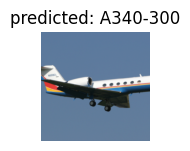

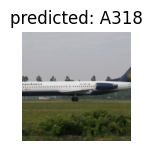

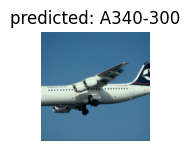

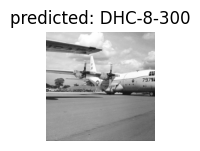

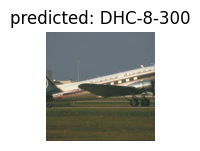

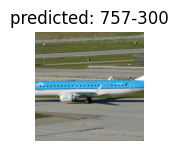

In [148]:
visualize_model(model_vgg16, test_dataloader, classes, 6)

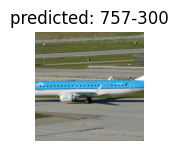

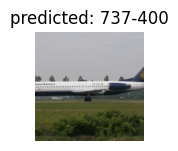

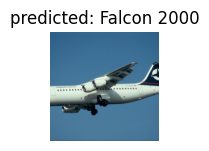

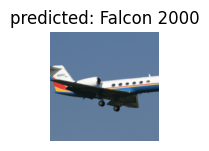

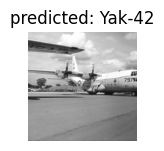

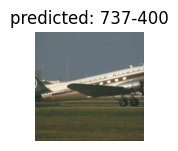

In [149]:
visualize_model(model_mobilenet_v3_large, test_dataloader, classes, 6)

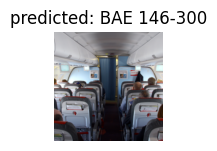

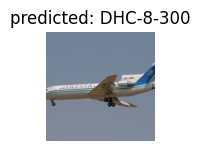

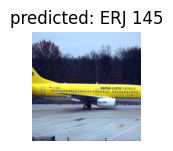

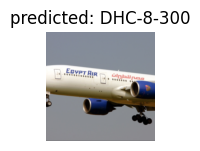

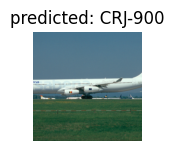

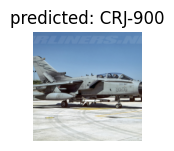

In [151]:
visualize_model(model_resnet50, test_dataloader, classes, 6)

***Graphs***

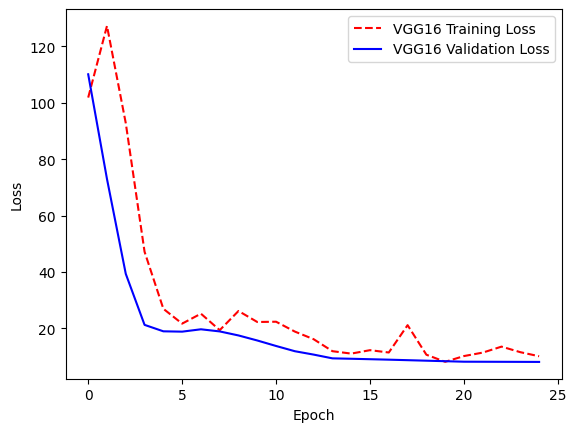

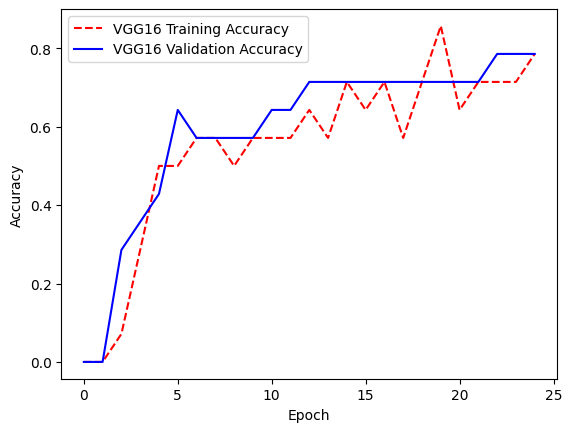

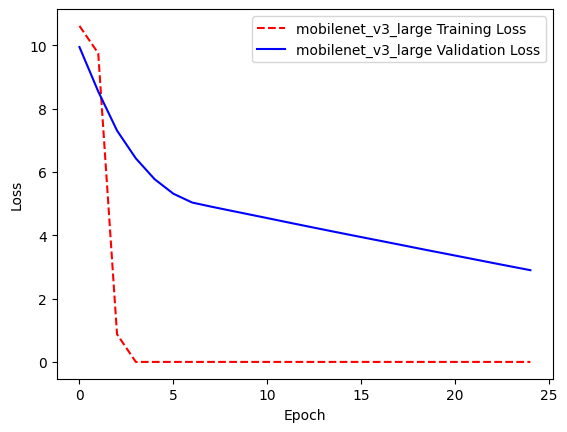

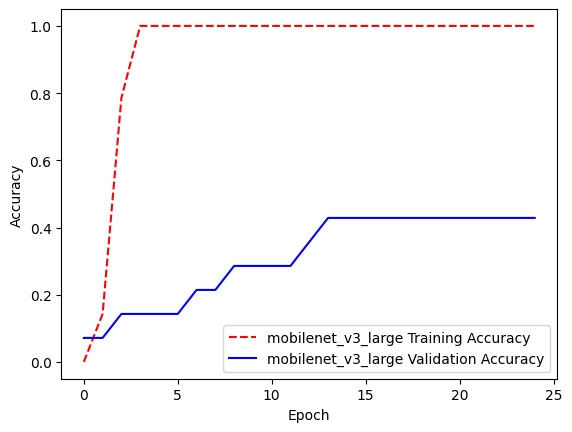

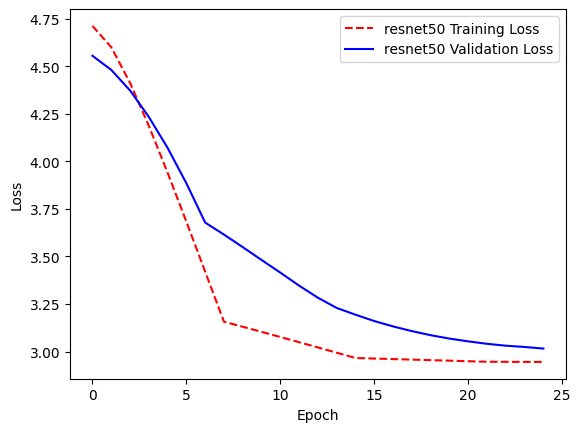

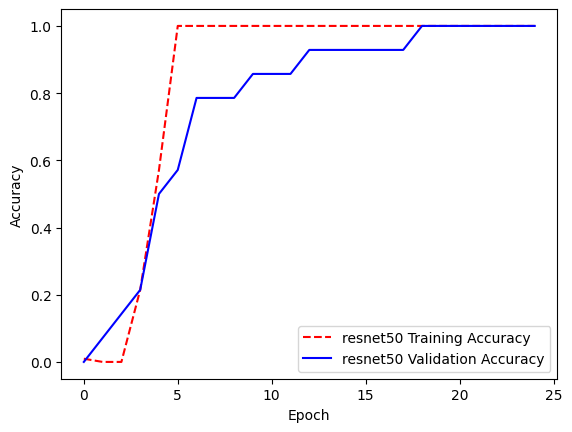

In [152]:
epochs = list()

for i in range(len(trainAcc_mobilenet_v3_large)):
  epochs.append(i)

#Train Loss vs Validation Loss
plt.plot(epochs, trainLoss_vgg16, 'r--')
plt.plot(epochs, valLoss_vgg16, 'b-')
plt.legend(['VGG16 Training Loss', 'VGG16 Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Train Accuracy vs Validation Accuracy
plt.plot(epochs, trainAcc_vgg16, 'r--')
plt.plot(epochs, valAcc_vgg16, 'b-')
plt.legend(['VGG16 Training Accuracy', 'VGG16 Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Train Loss vs Validation Loss
plt.plot(epochs, trainLoss_mobilenet_v3_large, 'r--')
plt.plot(epochs, valLoss_mobilenet_v3_large, 'b-')
plt.legend(['mobilenet_v3_large Training Loss', 'mobilenet_v3_large Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Train Accuracy vs Validation Accuracy
plt.plot(epochs, trainAcc_mobilenet_v3_large, 'r--')
plt.plot(epochs, valAcc_mobilenet_v3_large, 'b-')
plt.legend(['mobilenet_v3_large Training Accuracy', 'mobilenet_v3_large Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Train Loss vs Validation Loss
plt.plot(epochs, trainLoss_resnet50, 'r--')
plt.plot(epochs, valLoss_resnet50, 'b-')
plt.legend(['resnet50 Training Loss', 'resnet50 Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Train Accuracy vs Validation Accuracy
plt.plot(epochs, trainAcc_resnet50, 'r--')
plt.plot(epochs, valAcc_resnet50, 'b-')
plt.legend(['resnet50 Training Accuracy', 'resnet50 Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
